In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from tqdm import tqdm
import dill
from sklearn.linear_model import LinearRegression

In [2]:
# sell_prices = pd.read_csv('sell_prices.csv')
# calendar = pd.read_csv('calendar.csv')
# train = pd.read_csv('sales_train_validation.csv')
# submission = pd.read_csv('sample_submission.csv')
# sub1 = pd.read_csv('submission_tweedie.csv').set_index('id')
# sub2 = pd.read_csv('submission_poisson.csv').set_index('id').loc[sub1.index]
# sub3 = pd.read_csv('submission_custom.csv').set_index('id').loc[sub1.index]
# sub4 = pd.read_csv('submission_mae.csv').set_index('id').loc[sub1.index]

## LOWESS Regression

In [3]:
BASE     = 'data/m5-simple-fe/grid_part_1.pkl'
PRICE    = 'data/m5-simple-fe/grid_part_2.pkl'
CALENDAR = 'data/m5-simple-fe/grid_part_3.pkl'

In [4]:
df = pd.concat([pd.read_pickle(BASE),
                pd.read_pickle(PRICE).iloc[:,2:]],
#                 pd.read_pickle(CALENDAR).iloc[:,2:]],
                axis=1)
calendar = pd.read_pickle(CALENDAR)

In [5]:
df = df[df['d']<=1941]
df['revenue'] = df['sales'] * df['sell_price']
revenue = df.groupby(['d','store_id']).agg({'revenue':'sum'}).reset_index()

In [6]:
calendar[(calendar['tm_d']==25)&(calendar['tm_m']==12)]['d'].unique()

array(['d_331', 'd_697', 'd_1062', 'd_1427', 'd_1792'], dtype=object)

In [7]:
revenue = revenue[~revenue['d'].isin([331,697,1062,1427,1792])]

In [ ]:
last_100 = {}
for store_id in revenue['store_id'].unique():
    plt.plot(revenue[revenue['store_id']==store_id]['d'], revenue[revenue['store_id']==store_id]['revenue'])
    lowess = sm.nonparametric.lowess
    z = lowess(revenue[revenue['store_id']==store_id]['revenue'], revenue[revenue['store_id']==store_id]['d'])
    last_100[store_id] = z[-100:,1]
#     plt.plot(z[:,1])
#     plt.show()

In [9]:
next_28 = {}
for store_id, last_revenue in last_100.items():
    reg = LinearRegression().fit(np.arange(1, len(last_revenue)+1).reshape(-1,1), last_revenue)
    next_28[store_id] = reg.predict(np.arange(len(last_revenue)+1, len(last_revenue)+1+28).reshape(-1,1))
    print(reg.score(np.arange(1,len(last_revenue)+1).reshape(-1,1), last_revenue))

0.9999973669314766
0.9999535841868172
0.9999982231475051
0.9999995398619186
0.99999995242443
0.9999784455011484
0.9999997465320806
0.9999985295336993
0.9999788782203721
0.9999686841572965


In [ ]:
next_28

## Post-Processing

In [106]:
valid = pd.read_pickle('revenue_1914_1941_valid.pkl')
valid = valid.set_index('id').sort_index()
all_prices = pd.read_pickle('all_prices.pkl')
all_prices = all_prices.sort_index()
d2d_day_2 = pd.read_pickle('revenue_1914_1941_valid_detrend_d2.pkl')
d2d_day_2.set_index('id',inplace=True)
d2d_day_2 = d2d_day_2.sort_index()
trends = pd.read_pickle('data/m5-detrend/trend_sales_evaluation.pkl')
minus_trend = pd.read_pickle('data/m5-detrend/sales_minus_trend_evaluation.pkl')
train_df = pd.read_csv('data/m5-forecasting-accuracy/sales_train_evaluation.csv')

In [99]:
bottom_lines = minus_trend.iloc[:,1:].min(1).values
mean = train_df.iloc[:,6:].mean(1).values

In [100]:
bottom_lines

array([ 0.        ,  0.        ,  0.        , ..., -1.06127501,
        0.        , -2.04588799])

In [114]:
mean

array([0.32612056, 0.25759918, 0.15919629, ..., 0.89335394, 0.38073158,
       0.70273055])

In [102]:
trend = trends[:,-28:][:,1]

In [15]:
# past_total_revenue = revenue.groupby('d').agg({'revenue':'sum'}).values.reshape(-1)
# pred_total_revenue = valid.sum().values

In [16]:
# total_revenue_series = np.concatenate([past_total_revenue,pred_total_revenue])

In [17]:
# plt.plot(total_revenue_series)

In [18]:
# lowess = sm.nonparametric.lowess
# z = lowess(total_revenue_series, np.arange(1, len(total_revenue_series)+1))

In [19]:
# plt.plot(total_revenue_series)
# plt.plot(z[:,1])

In [107]:
valid['F2']=d2d_day_2['F2']

In [108]:
valid = valid/all_prices.iloc[:,1913:1941].values

In [109]:
valid.sum().values

array([37346.97952521, 63750.29614213, 34169.37282507, 34752.16488117,
       41322.65187344, 50985.58638139, 52975.73610856, 43908.22184974,
       44146.90739217, 38818.16236656, 40674.04928053, 45739.76724214,
       53948.51689994, 46437.11313966, 44899.70881531, 39409.98352797,
       40461.68936154, 41104.44196123, 44371.39571685, 54020.21036345,
       56365.66285707, 42117.58159902, 38086.54974224, 37250.78425265,
       37231.75942256, 42152.83212667, 50869.81500775, 51677.46493856])

In [110]:
valid = valid.loc[train_df['id']]

In [111]:
valid['F2'] = valid['F2']-mean+bottom_lines+trend

In [112]:
valid.sum().values

array([37346.97952521, 19069.83288693, 34169.37282507, 34752.16488117,
       41322.65187344, 50985.58638139, 52975.73610856, 43908.22184974,
       44146.90739217, 38818.16236656, 40674.04928053, 45739.76724214,
       53948.51689994, 46437.11313966, 44899.7088153 , 39409.98352797,
       40461.68936154, 41104.44196123, 44371.39571685, 54020.21036345,
       56365.66285707, 42117.58159902, 38086.54974224, 37250.78425265,
       37231.75942256, 42152.83212667, 50869.81500775, 51677.46493856])

In [48]:
sales = df.groupby('d').agg({'sales':'sum'})

In [ ]:
valid.sum()

### Evaluator

In [94]:
from typing import Union

import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [95]:
train_df = pd.read_csv('data/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar = pd.read_csv('data/m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('data/m5-forecasting-accuracy/sell_prices.csv')

train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_df.iloc[:, -28:].copy()

e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)

100%|██████████| 42840/42840 [00:06<00:00, 6504.09it/s]


In [96]:
valid_preds = valid.loc[train_fold_df['id']].values
e.score(valid_preds)

0.5620809194542171

In [61]:
sample_submission = pd.read_csv('data/m5-forecasting-accuracy/sample_submission.csv')

In [71]:
sample_submission.iloc[:30490,1:] = valid_preds

In [73]:
sample_submission.to_csv('evaluator_submission.csv',index=False)

In [74]:
!kaggle competitions submit -c m5-forecasting-accuracy -f evaluator_submission.csv -m "evaluator"

100%|██████████████████████████████████████| 20.5M/20.5M [00:01<00:00, 10.8MB/s]
Successfully submitted to M5 Forecasting - Accuracy

In [ ]:
# plt.plot(train)
for i in range(6):
    plt.plot(sub1.iloc[i,1:].values)

In [ ]:
# plt.plot(train)
for i in range(6):
    plt.plot(sub2.iloc[i,1:].values)

In [ ]:
# plt.plot(train)
for i in range(6):
    plt.plot(sub3.iloc[i,1:].values)

In [ ]:
# plt.plot(train)
for i in range(6):
    plt.plot(sub4.iloc[i,1:].values)

In [ ]:
for i in range(6):
    plt.plot(train.iloc[i, 1900:].values)

In [30]:
# zero_dict = {}
# for i in tqdm(range(len(train))):
#     ori_sales = train.iloc[i,6:].values
#     sales = np.trim_zeros(ori_sales, 'f')
# #     zero_percent = 1-len(sales.nonzero()[0])/len(sales)
#     id = '_'.join(train.iloc[i,0].split('_')[:-1])
#     zero_dict[id]=sales

100%|██████████| 30490/30490 [00:45<00:00, 667.56it/s]


In [3]:
def moving_average(a, n=28) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [245]:
moving_avg_dict = {}
for i in tqdm(range(len(train))):
    ori_sales = train.iloc[i,6:].values
    sales = np.trim_zeros(ori_sales, 'f')
#     zero_percent = 1-len(sales.nonzero()[0])/len(sales)
    id = '_'.join(train.iloc[i,0].split('_')[:-1])
    moving_avg_dict[id]=moving_average(sales)

100%|██████████| 30490/30490 [00:48<00:00, 629.80it/s]


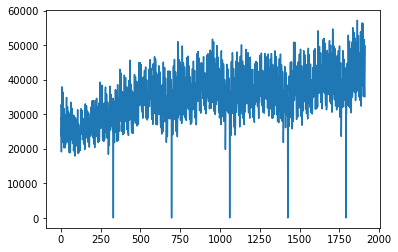

In [270]:
plt.plot(train.iloc[:,6:].sum().values)

In [4]:
moving_avg_all_dict = {}
for i in tqdm(range(len(train))):
    ori_sales = train.iloc[i,6:].values
#     sales = np.trim_zeros(ori_sales, 'f')
#     zero_percent = 1-len(sales.nonzero()[0])/len(sales)
    id = '_'.join(train.iloc[i,0].split('_')[:-1])
    moving_avg_all_dict[id]=moving_average(ori_sales)

100%|██████████| 30490/30490 [00:31<00:00, 979.81it/s] 


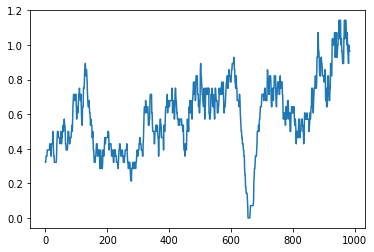

In [247]:
plt.plot(list(moving_avg_dict.values())[0])

In [248]:
moving_avg = list(moving_avg_dict.values())

In [263]:
moving_avg_include = [i for i in moving_avg if len(i)>1500]

In [264]:
len(moving_avg_include)

17596

In [265]:
moving_avg_for_trend = [i[len(i)-1500:] for i in moving_avg_include]

In [266]:
sum_moving_avg = np.sum(moving_avg_for_trend,axis=0)

In [ ]:
plt.plot(sum_moving_avg)

In [5]:
sum_moving_avg_all = np.sum(list(moving_avg_all_dict.values()),axis=0)

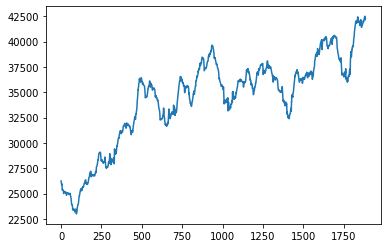

In [6]:
plt.plot(sum_moving_avg_all)

In [7]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm

In [50]:
model = ExponentialSmoothing(sum_moving_avg_all[:], trend="add", seasonal="add", seasonal_periods=365,damped=True)
fit = model.fit()

/home/chens/anaconda3/envs/schen/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [51]:
pred = fit.forecast(28)

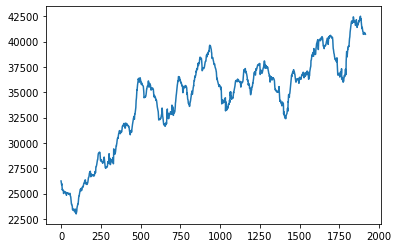

In [52]:
plt.plot(np.concatenate([sum_moving_avg_all, pred]))

In [53]:
pred

array([42126.37687614, 41999.65491802, 41892.36377429, 41642.88763631,
       41447.27084761, 41290.9915936 , 41297.53601777, 41415.87506342,
       41273.47101623, 41144.08780017, 41084.86687702, 40988.45453965,
       40960.93591374, 40937.25747208, 40718.18026875, 40764.79070308,
       40793.25909588, 40733.90326422, 40757.22180992, 40898.22985176,
       40902.37098563, 40824.48398606, 40870.78371094, 40862.83739177,
       40833.06553569, 40789.76384456, 40794.52221954, 40729.49700458])

In [ ]:
model = pm.auto_arima(sum_moving_avg_all, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=365,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,  
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic


In [54]:
sub1.sum().mean()

43528.543291164846

In [55]:
40729.49700458/43528.543291164846

0.9356963023581591

In [56]:
my_sub = (sub1*0.9356963023581591)

In [ ]:
for i in tqdm(range(len(train))):
    train.iloc[i,0]

In [5]:
sub1['min_id'] = sub1.index.str.split('_')

In [6]:
for i in tqdm(range(len(sub1))):
    item_id = sub1.iloc[i,-1]
    sub1.iloc[i,-1] = '_'.join(item_id[:-1])

100%|██████████| 60980/60980 [02:35<00:00, 392.02it/s]


In [7]:
# sub4['min_id'] = sub1.iloc[:,-1]

In [8]:
# dill.dump(zero_dict,open('./zero_dict.pkl','wb'))
zero_dict = dill.load(open('./zero_dict.pkl','rb'))

In [104]:
my_sub = sub1.drop(columns=['min_id'])

In [105]:
for i in tqdm(range(len(sub1))):
    item_id = sub1.iloc[i,-1]
    preds = my_sub.values[i].copy()
    preds_mae = np.clip(sub4.values[i],0,None)
    percentile = int(zero_dict[item_id][0]*50)
    threshold = np.percentile(preds,percentile)
    if len(preds[preds<threshold])>0:
#         print(len(preds[preds<threshold]))
        preds[preds<threshold]=preds_mae[preds<threshold]
#         print(preds.mean()/my_sub.values[i].mean())
        my_sub.values[i] *= (preds.mean()/my_sub.values[i].mean())
#     my_sub.iloc[i] = preds
#     break

100%|██████████| 60980/60980 [00:07<00:00, 7839.90it/s]


In [57]:
my_sub.reset_index().to_csv('submission.csv',index=False)

In [58]:
!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "50% mean"

100%|██████████████████████████████████████| 20.5M/20.5M [00:03<00:00, 6.74MB/s]
Successfully submitted to M5 Forecasting - Accuracy

In [ ]:
my_sub.reset_index()

In [31]:
i=8

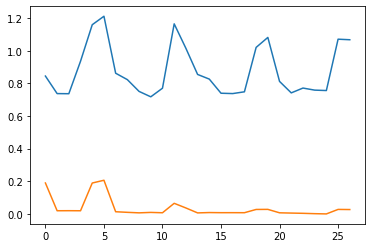

In [32]:
plt.plot(sub1.iloc[i,1:].values)
# plt.plot(sub2.iloc[i,1:].values)
# plt.plot(sub3.iloc[i,1:].values)
plt.plot(sub4.iloc[i,1:].values)

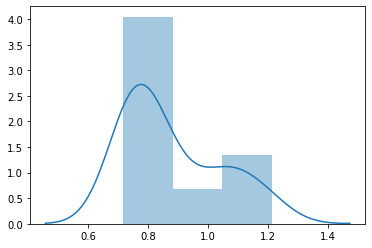

In [33]:
sns.distplot(sub1.iloc[i, 1:].values)

In [37]:
sub4.iloc[i, 1:].values

array([ 0.18918612,  0.01896877,  0.01929055,  0.01890003,  0.18893385,
        0.20594392,  0.01287178,  0.00923716,  0.00608071,  0.00876671,
        0.00660183,  0.06452668,  0.03599041,  0.00573799,  0.00790749,
        0.00706318,  0.00715001,  0.00692297,  0.02689455,  0.02739907,
        0.00631432,  0.00472232,  0.00320752,  0.00103662, -0.00047203,
        0.02713977,  0.02633217])

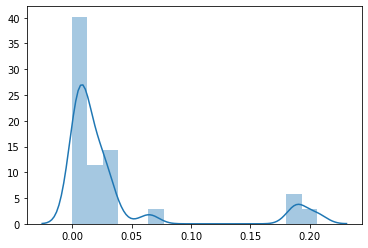

In [34]:
sns.distplot(sub4.iloc[i, 1:].values)

In [35]:
zero_dict['_'.join(sub1.index[i].split('_')[:-1])][0]

0.5399895452169368

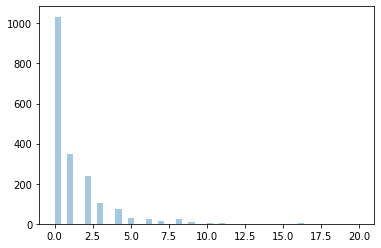

In [36]:
sns.distplot(train.iloc[i, 6+zero_dict['_'.join(sub1.index[i].split('_')[:-1])][1]:].values,kde=False)

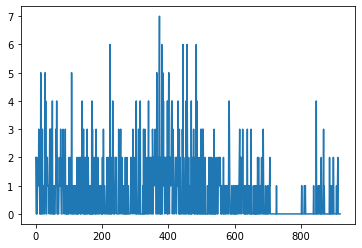

In [141]:
plt.plot(train.iloc[i, 1000:].values)

In [ ]:
train

In [68]:
sub.iloc[0,1:]

F1     0.754956
F2     0.710293
F3     0.723041
F4     0.757371
F5     0.930978
F6       1.0174
F7      1.14976
F8     0.850865
F9     0.856534
F10     0.76304
F11    0.743174
F12    0.892645
F13     1.06641
F14     0.83836
F15    0.849109
F16    0.818085
F17    0.749403
F18    0.734498
F19    0.770908
F20     0.94337
F21    0.963763
F22    0.812957
F23    0.757883
F24    0.723716
F25       0.773
F26    0.877107
F27     1.03438
F28    0.944918
Name: 0, dtype: object